# Hyperbolic unitary overlap cost function ADAM gradient descent on two sided MPO - SPT extraction sweep

Created 20/11/2024

Objectives:
* Apply ADAM gradient descent algorithm to an MPO and extract SPT phase for two sided MPO, i.e. unitaries on either side of the symmetry action.

# Package imports

In [1]:
import sys

In [2]:
sys.path.append("../../")

In [3]:
import h5py
from tenpy.tools import hdf5_io
import tenpy
import tenpy.linalg.np_conserved as npc

import os

In [4]:
from functools import reduce

In [5]:
import numpy as np
import pandas as pd

rng = np.random.default_rng()
import matplotlib.pyplot as plt

In [6]:
import re

In [40]:
from SPTOptimization.utils import (
    get_right_identity_environment_from_tp_tensor,
    get_left_identity_environment_from_tp_tensor,
    to_npc_array
)

from SPTOptimization.SymmetryActionWithBoundaryUnitaries import SymmetryActionWithBoundaryUnitaries

# Load data

In [8]:
DATA_DIR = r"../../data/transverse_cluster_200_site_dmrg"

In [9]:
loaded_data = list()

for local_file_name in os.listdir(DATA_DIR):
    f_name = r"{}/{}".format(DATA_DIR, local_file_name, ignore_unknown=False)
    with h5py.File(f_name, 'r') as f:
        data = hdf5_io.load_from_hdf5(f)
        loaded_data.append(data)

In [10]:
b_parameters = sorted(list(d['paramters']['B'] for d in loaded_data))

In [11]:
psi_dict = dict()

In [12]:
for b in b_parameters:
    psi = next(
        d['wavefunction']
        for d in loaded_data
        if d['paramters']['B'] == b
    )

    rounded_b = round(b, 1)
    psi_dict[rounded_b] = psi

# Definitons

In [13]:
np_I = np.array([[1,0],[0,1]])
np_X = np.array([[0,1],[1,0]])
np_Y = np.array([[0,-1j],[1j,0]])
np_Z = np.array([[1,0],[0,-1]])

In [14]:
symmetry_actions = [
    [np_I, np_I],
    [np_I, np_X],
    [np_X, np_I],
    [np_X, np_X]
]

In [15]:
symmetry_labels = [
    'II',
    'IX',
    'XI',
    'XX'
]

In [16]:
cases = [
    [
        SymmetryActionWithBoundaryUnitaries(
            psi,
            s*50,
            left_boundary_unitaries=[np_I,]*3,
            right_boundary_unitaries=[np_I,]*3
        )
        for s in symmetry_actions
    ]
    for psi in psi_dict.values()
]

In [17]:
for l in cases:
    for c in l:
        c.compute_svd_approximate_expectation()

In [18]:
left_trivial_leg_charge = tenpy.linalg.charges.LegCharge(
    tenpy.linalg.charges.ChargeInfo([], []),
    [0,1],
    [[]],
    qconj=1
)

In [19]:
right_trivial_leg_charge = tenpy.linalg.charges.LegCharge(
    tenpy.linalg.charges.ChargeInfo([], []),
    [0,1],
    [[]],
    qconj=-1
)

## Functions

In [20]:
def get_physical_dim(tensor, p_label='p'):
    index = tensor.get_leg_index(p_label)
    dim = tensor.shape[index]
    return dim

In [21]:
def mpo_frobenius_inner_product(mpo1_tensors, mpo2_tensors=None):
    if mpo2_tensors is None:
        mpo2_tensors = mpo1_tensors

    w1 = mpo1_tensors[0]
    dim = get_physical_dim(w1, p_label='p')
    w2 = mpo2_tensors[0]

    t = npc.tensordot(w1, w2.conj(), [['p', 'p*'], ['p*', 'p']])
    #t /= dim

    for w1, w2 in zip(mpo1_tensors[1:], mpo2_tensors[1:]):
        dim = get_physical_dim(w1, p_label='p')

        t = npc.tensordot(t, w1, [['vR', ], ['vL']])
        t = npc.tensordot(t, w2.conj(), [['vR*', 'p', 'p*'], ['vL*', 'p*', 'p']])
        #t /= dim

    return t

In [22]:
def unitary_order_two_right_tensors(w_tensors):
    out = list()

    w = w_tensors[-1]
    t = npc.tensordot(w, w.conj(), [['p', 'p*'], ['p*', 'p']])

    out.append(t)

    for w in w_tensors[-2:0:-1]:
        t = npc.tensordot(t, w, [['vL',], ['vR']])
        t = npc.tensordot(t, w.conj(), [['vL*', 'p', 'p*'], ['vR*', 'p*', 'p']])

        out.append(t)

    return out[::-1]

In [23]:
def unitary_order_four_right_tensors(w_tensors):
    out = list()

    w = w_tensors[-1]
    t = npc.tensordot(w, w.conj(), [['p',], ['p*',]])
    t.ireplace_labels(['vL', 'vL*'], ['vL1', 'vL1*'])
    t = npc.tensordot(t, w, [['p',], ['p*',]])
    t = npc.tensordot(t, w.conj(), [['p', 'p*'], ['p*', 'p']])
    
    out.append(t)

    for w in w_tensors[-2:0:-1]:
        t = npc.tensordot(t, w, [['vL',], ['vR',]])
        t = npc.tensordot(t, w.conj(), [['vL*', 'p'], ['vR*', 'p*']])

        w = w.replace_label('vL', 'vL1')
    
        t = npc.tensordot(t, w, [['vL1', 'p',], ['vR', 'p*']])
        t = npc.tensordot(t, w.conj(), [['vL1*', 'p', 'p*'], ['vR*', 'p*', 'p']])

        out.append(t)

    return out[::-1]

In [55]:
def overlap_right_tensors(w_tensors, b_tensors):
    out = list()

    t = get_right_identity_environment_from_tp_tensor(b_tensors[-1])

    out.append(t)

    # First site
    b = b_tensors[-1]
    w = w_tensors[-1]
    
    t = npc.tensordot(t, b, [['vL',], ['vR',]])
    t = npc.tensordot(
        t,
        w.replace_label('vL', 'vLm'),
        [['p',], ['p*',]]
    )
    t = npc.tensordot(t, b.conj(), [['p', 'vL*',], ['p*', 'vR*',]])

    out.append(t)

    # Inner sites
    for w, b in zip(w_tensors[-2:0:-1], b_tensors[-2:0:-1]):
        t = npc.tensordot(t, b, [['vL',], ['vR',]])
        t = npc.tensordot(
            t,
            w.replace_label('vL', 'vLm'),
            [['p', 'vLm'], ['p*', 'vR']]
        )
        t = npc.tensordot(t, b.conj(), [['p', 'vL*',], ['p*', 'vR*',]])
    
        out.append(t)

    # Last site
    b = b_tensors[0]
    w = w_tensors[0]

    t = npc.tensordot(t, b, [['vL',], ['vR',]])
    t = npc.tensordot(
        t,
        w,
        [['p', 'vLm'], ['p*', 'vR']]
    )
    t = npc.tensordot(t, b.conj(), [['p', 'vL*',], ['p*', 'vR*',]])

    out.append(t)

    return out[::-1]

### Initialize tensors

In [25]:
def rescale_mpo_tensors(mpo_tensors, new_norm):
    num_sites = len(mpo_tensors)

    old_norm = mpo_frobenius_inner_product(mpo_tensors).real
    
    scale_factor = np.power(
        new_norm/old_norm,
        1/(2*num_sites)
    )

    for i in range(num_sites):
        mpo_tensors[i] = scale_factor*mpo_tensors[i]

In [26]:
def generate_random_w_tensor(physical_dim, left_virtual_dim=None,
                             right_virtual_dim=None):

    if (left_virtual_dim is None) and (right_virtual_dim is None):
        dims = (physical_dim, physical_dim)
    elif (left_virtual_dim is None):
        dims = (physical_dim, physical_dim, right_virtual_dim)
    elif (right_virtual_dim is None):
        dims = (physical_dim, physical_dim, left_virtual_dim)
    else: 
        dims = (
            physical_dim,
            physical_dim,
            left_virtual_dim,
            right_virtual_dim
        )
    
    X1 = rng.normal(size=dims)
    X2 = 1j*rng.normal(size=dims)
    X = X1 + X2

        
    if (left_virtual_dim is None) and (right_virtual_dim is None):
        out = npc.Array.from_ndarray_trivial(X, labels=['p', 'p*'])
    elif right_virtual_dim is None:
        out = npc.Array.from_ndarray_trivial(X, labels=['p', 'p*', 'vL'])
    elif left_virtual_dim is None:
        out = npc.Array.from_ndarray_trivial(X, labels=['p', 'p*', 'vR'])
    else:
        out = npc.Array.from_ndarray_trivial(
            X,
            labels=['p', 'p*', 'vL', 'vR']
        )

    return out

In [27]:
def get_random_mpo_tensors(num_sites, norm=None):
    """
    Needs more arguments
    """

    w = generate_random_w_tensor(edge_dims)
    w_tensor = npc.Array.from_ndarray_trivial(
        w,
        labels=['p', 'p*', 'vR']
    )

    w_tensors = [w_tensor,]

    for _ in range(num_sites-2):
        w = generate_random_w_tensor(inner_dims)
        w_tensor = npc.Array.from_ndarray_trivial(w, labels=['p', 'p*', 'vL', 'vR'])
        
        w_tensors.append(w_tensor)

    w = generate_random_w_tensor(edge_dims)
    w_tensor = npc.Array.from_ndarray_trivial(
        w,
        labels=['p', 'p*', 'vL']
    )
    w_tensors.append(w_tensor)

    if norm is not None:
        rescale_mpo_tensors(w_tensors, norm)

    return w_tensors

In [28]:
def get_identity_w_tensor(physical_dim, left_virtual_dim=None, right_virtual_dim=None):
    diagonal = np.ones(physical_dim, dtype='complex')
    identity_matrix = np.diag(diagonal)
    
    if (left_virtual_dim is None) and (right_virtual_dim is None):
        w_tensor = npc.Array.from_ndarray_trivial(
            identity_matrix,
            labels=['p', 'p*']
        )
    elif right_virtual_dim is None:
        X = np.zeros(
            (physical_dim, physical_dim, left_virtual_dim),
            dtype='complex'
        )
        X[...,0] = identity_matrix
        w_tensor = npc.Array.from_ndarray_trivial(
            X,
            labels=['p', 'p*', 'vL']
        )
    elif left_virtual_dim is None:
        X = np.zeros(
            (physical_dim, physical_dim, right_virtual_dim),
            dtype='complex'
        )
        X[...,0] = identity_matrix
        w_tensor = npc.Array.from_ndarray_trivial(
            X,
            labels=['p', 'p*', 'vR']
        )
    else:
        X = np.zeros(
            (physical_dim, physical_dim, left_virtual_dim, right_virtual_dim),
            dtype='complex'
        )
        X[...,0,0] = identity_matrix
        w_tensor = npc.Array.from_ndarray_trivial(
            X,
            labels=['p', 'p*', 'vL', 'vR']
        )

    return w_tensor

In [29]:
def get_random_mpo_tensors(physical_dims, virtual_dims):
    """
    Could fold in with get_identity_mpo_tensors
    """

    w_tensors = [
        generate_random_w_tensor(p_dim, *v_dims)
        for p_dim, v_dims in zip(physical_dims, virtual_dims)
    ]

    return w_tensors

In [30]:
def get_identity_mpo_tensors(physical_dims, virtual_dims):
    """
    Needs more comments, docs!

    Often physical dims, virtual dims will be the same, so could add
    optional behaviour...
    """

    w_tensors = [
        get_identity_w_tensor(p_dim, *v_dims)
        for p_dim, v_dims in zip(physical_dims, virtual_dims)
    ]

    return w_tensors

### ADAM functions

In [31]:
def squared_components(X):
    r, i = (X.real, X.imag)
    return r**2 + 1j*(i**2)

In [32]:
def square_root_components(X):
    r, i = (X.real, X.imag)
    return np.sqrt(r) + 1j*np.sqrt(i)

In [33]:
class AdamTenpy:
    def __init__(self, alpha=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8):
        self.alpha = alpha
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.epsilon = epsilon

        self.moment_1 = None
        self.moment_2 = None

    def update(self, grad):
        if self.moment_1 is None:
            self.moment_1 = (1-self.beta_1)*grad
        else:
            self.moment_1 = self.beta_1*self.moment_1 + (1-self.beta_1)*grad

        grad_squared = grad.unary_blockwise(squared_components)
        if self.moment_2 is None:
            self.moment_2 = (1-self.beta_2)*grad_squared
        else:
            self.moment_2 = self.beta_2*self.moment_2 + (1-self.beta_2)*grad_squared

        self.moment_1 /= (1-self.beta_1)
        self.moment_2 /= (1-self.beta_2)

        out_grad_denom = (
            self.moment_2
            .unary_blockwise(square_root_components)
            .unary_blockwise(lambda x: x + (1+1j)*self.epsilon)
        )

        out_grad = (
            self.moment_1
            .binary_blockwise(np.divide, out_grad_denom)
        )

        return self.alpha*out_grad

### Sweep function

In [34]:
def mpo_tensor_raw_to_gradient(raw_mpo_tensor, gradient_target_tensor):
    """
    Update raw_mpo_tensor calculated to be the gradient by changing leg names
    as neeeded so can be easily and consistently added to
    gradient_target_tensor.
    """
    leg_labels = raw_mpo_tensor.get_leg_labels()

    # First update the virtual legs
    old_new_leg_label_pairs = [
        ('vL*', 'vR'),
        ('vR*', 'vL'),
        ('vL1*', 'vR'),
        ('vR1*', 'vL'),
        ('vLm', 'vR'),
        ('vRm', 'vL'),
    ]

    for old, new in old_new_leg_label_pairs:
        if old in leg_labels:
            raw_mpo_tensor.ireplace_label(old, new)

    # Then create new array to get the physical legs correct.
    # Is this consistent? Should set order of leg labels on raw_mpo_tensor
    # before casting to array?
    out = npc.Array.from_ndarray_trivial(
        raw_mpo_tensor.to_ndarray(),
        labels=raw_mpo_tensor.get_leg_labels()
    )

    out.itranspose(gradient_target_tensor.get_leg_labels())

    return out

In [35]:
def update_mpo_score(raw_gradient_mpo_tensor, gradient_target_tensor,
                     virtual_legs=[['vL*', 'vR*',], ['vR*', 'vL*',]],
                     take_abs=False
                    ):
    # Calculate "score" (just the contraction of the two relevant tensors)
    raw_legs, target_legs = virtual_legs

    score = npc.tensordot(
        raw_gradient_mpo_tensor,
        gradient_target_tensor.conj(),
        [['p', 'p*', *raw_legs], ['p*', 'p', *target_legs]]
    )

    if take_abs:
        real_score = np.abs(score)
    else:
        real_score = score.real

    return score

In [78]:
def mpo_gradient_descent_sweep(mpo_tensors, b_tensors, right_overlap_tensors,
    unitarity_learning_rate, overlap_learning_rate, overlap_target,
    left_environment, adam_optimizers):
    """
    Really need to tidy this function up...

    Also get matrix_dim directly from tensors.
    """
    # Initialise list of gradients to be filled
    grads = list()
    # HARD CODE WARNING!
    total_dimension = 2**len(mpo_tensors)

    # Initialise variables
    right_unitary_two_tensors = unitary_order_two_right_tensors(mpo_tensors)
    right_unitary_four_tensors = unitary_order_four_right_tensors(mpo_tensors)
    
    left_unitary_two_tensors = list()
    left_unitary_four_tensors = list()
    left_overlap_tensors = list()

    num_sites = len(mpo_tensors)
    assert len(mpo_tensors) == len(b_tensors)

    # Leftmost site
    w = mpo_tensors[0]
    b = b_tensors[0]

    t = right_unitary_two_tensors[0]

    # Second order terms
    grad_2 = npc.tensordot(t, w, [['vL'], ['vR',]])

    order_2_score = update_mpo_score(
        grad_2,
        w,
        [['vL*',], ['vR*',]]
    )

    grad_2 = mpo_tensor_raw_to_gradient(grad_2, w)

    # Fourth order terms
    t = right_unitary_four_tensors[0]

    grad_4 = npc.tensordot(t, w, [['vL'], ['vR',]])
    grad_4 = npc.tensordot(grad_4, w.conj(), [['vL*', 'p'], ['vR*', 'p*']])
    grad_4 = npc.tensordot(grad_4, w, [['vL1', 'p'], ['vR', 'p*']])

    order_4_score = update_mpo_score(
        grad_4,
        w,
        [['vL1*',], ['vR*',]]
    )

    grad_4 = mpo_tensor_raw_to_gradient(grad_4, w)

    unitary_score = order_4_score - 2*order_2_score + total_dimension
    unitary_grad = (grad_4 - grad_2)/np.sqrt(1+unitary_score)
    
    # Overlap terms
    t = right_overlap_tensors[0].conj().replace_label('vLm*', 'vLm')

    grad_o = npc.tensordot(t, b, [['vL'], ['vR',]])
    grad_o = npc.tensordot(grad_o, b.conj(), [['vL*',], ['vR*',]])
    grad_o = npc.tensordot(grad_o, left_environment, [['vL', 'vL*'], ['vR', 'vR*']])

    c_conj = update_mpo_score(
        grad_o,
        w,
        [['vLm',], ['vR*',]],
        take_abs=True
    )
    c = c_conj.conjugate()
    c_abs = np.abs(c)
    
    grad_o_scale = c*(1 - overlap_target/c_abs)
    grad_o = grad_o_scale*grad_o
    grad_o = mpo_tensor_raw_to_gradient(grad_o, w)

    grad = (
        unitarity_learning_rate*unitary_grad +
        overlap_learning_rate*grad_o
    )
    adam_grad = adam_optimizers[0].update(grad)
    grads.append(adam_grad)

    # Create and save left tensors
    t = npc.tensordot(w, w.conj(), [['p', 'p*'], ['p*', 'p']])
    left_unitary_two_tensors.append(t)
    
    t = npc.tensordot(w, w.conj(), [['p',], ['p*',]])
    t.ireplace_labels(['vR', 'vR*'], ['vR1', 'vR1*'])
    t = npc.tensordot(t, w, [['p',], ['p*',]])
    t = npc.tensordot(t, w.conj(), [['p', 'p*'], ['p*', 'p']])
    
    left_unitary_four_tensors.append(t)

    t = npc.tensordot(b, w.conj(), [['p',], ['p*',]])
    #print(t)
    t.ireplace_label('vR*', 'vRm')
    #print(t)
    t = npc.tensordot(t, left_environment, [['vL',], ['vR',]])
    #print(t)
    t = npc.tensordot(t, b.conj(), [['vR*', 'p'], ['vL*', 'p*']])

    #print(t)

    left_overlap_tensors.append(t)

    # Inner sites
    for i in range(1, num_sites-1):
        w = mpo_tensors[i]
        b = b_tensors[i]
    
        right_two_tensor = right_unitary_two_tensors[i]
        right_four_tensor = right_unitary_four_tensors[i]
        right_overlap_tensor = right_overlap_tensors[i].conj().replace_label('vLm*', 'vLm')

        # Order two terms
        left_two_tensor = left_unitary_two_tensors[-1]

        grad_2 = npc.tensordot(right_two_tensor, w, [['vL'], ['vR',]])
        grad_2 = npc.tensordot(grad_2, left_two_tensor, [['vL'], ['vR',]])

        grad_2 = mpo_tensor_raw_to_gradient(grad_2, w)

        # Order four terms
        left_four_tensor = left_unitary_four_tensors[-1]

        grad_4 = npc.tensordot(right_four_tensor, w, [['vL'], ['vR',]])
        grad_4 = npc.tensordot(grad_4, w.conj(), [['vL*', 'p'], ['vR*', 'p*']])

        grad_4 = npc.tensordot(
            grad_4,
            w.replace_label('vL', 'vL1'),
            [['vL1', 'p'], ['vR', 'p*']]
        )

        grad_4 = npc.tensordot(
            grad_4,
            left_four_tensor,
            [['vL', 'vL*', 'vL1'], ['vR', 'vR*', 'vR1']]
        )

        grad_4 = mpo_tensor_raw_to_gradient(grad_4, w)

        unitary_grad = (grad_4 - grad_2)/np.sqrt(1+unitary_score)
    
        # Overlap terms
        left_overlap_tensor = left_overlap_tensors[-1]

        grad_o = npc.tensordot(right_overlap_tensor, b, [['vL',], ['vR',]])
        grad_o = npc.tensordot(grad_o, b.conj(), [['vL*',], ['vR*',]])
        grad_o = npc.tensordot(
            grad_o,
            left_overlap_tensor,
            [['vL*', 'vL'], ['vR', 'vR*',]]
        )

        grad_o = grad_o_scale*grad_o
        grad_o = mpo_tensor_raw_to_gradient(grad_o, w)

        grad = (
            unitarity_learning_rate*unitary_grad +
            overlap_learning_rate*grad_o
        )
        adam_grad = adam_optimizers[i].update(grad)
        grads.append(adam_grad)

        # Update left tensors
        t = npc.tensordot(left_two_tensor, w, [['vR',], ['vL']])
        t = npc.tensordot(
            t,
            w.conj(),
            [['vR*', 'p', 'p*'], ['vL*', 'p*', 'p']]
        )
        
        left_unitary_two_tensors.append(t)
        
        t = npc.tensordot(left_four_tensor, w, [['vR',], ['vL']])
        t = npc.tensordot(t, w.conj(), [['vR*', 'p'], ['vL*', 'p*']])
        t = npc.tensordot(
            t,
            w.replace_label('vR', 'vR1'),
            [['p', 'vR1'], ['p*', 'vL']]
        )
        t = npc.tensordot(
            t,
            w.conj().replace_label('vR*', 'vR1*'),
            [['p', 'p*', 'vR1*'], ['p*', 'p', 'vL*']]
        )
        
        left_unitary_four_tensors.append(t)

        t = left_overlap_tensor.ireplace_label('vR*', 'vR1*')
        t = npc.tensordot(
            left_overlap_tensor,
            w.conj(),
            [['vRm',], ['vL*']]
        )
        t.ireplace_label('vR*', 'vRm')
        t = npc.tensordot(t, b, [['vR', 'p*'], ['vL', 'p']])
        t = npc.tensordot(t, b.conj(), [['vR1*', 'p'], ['vL*', 'p*']])

        left_overlap_tensors.append(t)

    # Last site
    left_two_tensor = left_unitary_two_tensors[-1]
    w = mpo_tensors[-1]
    b = b_tensors[-1]
    
    grad_2 = npc.tensordot(left_two_tensor, w, [['vR'], ['vL',]])
    grad_2 = mpo_tensor_raw_to_gradient(grad_2, w)

    left_four_tensor = left_unitary_four_tensors[-1]
    
    grad_4 = npc.tensordot(left_four_tensor, w, [['vR'], ['vL',]])
    grad_4 = npc.tensordot(grad_4, w.conj(), [['vR*', 'p'], ['vL*', 'p*']])
    grad_4 = npc.tensordot(grad_4, w, [['vR1', 'p'], ['vL', 'p*']])

    grad_4 = mpo_tensor_raw_to_gradient(grad_4, w)
    
    unitary_grad = (grad_4 - grad_2)/np.sqrt(1+unitary_score)

    left_overlap_tensor = left_overlap_tensors[-1]
    right_overlap_tensor = right_overlap_tensors[-1].conj()

    grad_o = npc.tensordot(right_overlap_tensor, b, [['vL',], ['vR',]])
    grad_o = npc.tensordot(grad_o, b.conj(), [['vL*',], ['vR*',]])
    grad_o = npc.tensordot(
        grad_o,
        left_overlap_tensor,
        [['vL*', 'vL'], ['vR', 'vR*',]]
    )

    grad_o = grad_o_scale*grad_o
    grad_o = mpo_tensor_raw_to_gradient(grad_o, w)


    grad = (
        unitarity_learning_rate*unitary_grad +
        overlap_learning_rate*grad_o
    )
    adam_grad = adam_optimizers[-1].update(grad)
    grads.append(adam_grad)

    """
    for i, g in enumerate(grads):
        mpo_tensors[i] = mpo_tensors[i] - g
    """
    
    return (grads, unitary_score, c_abs)

In [42]:
def swap_left_right_indices(npc_array):
    left_right_pairs = {
        'vL': 'vR',
        'vR': 'vL',
        'vL*': 'vR*',
        'vR*': 'vL*'
    }

    leg_labels = npc_array.get_leg_labels()

    old_labels = [l for l in leg_labels if l in left_right_pairs]
    new_labels = [left_right_pairs[l] for l in old_labels]

    out = npc_array.replace_labels(old_labels, new_labels)

    return out

In [64]:
def two_sided_mpo_gradient_descent_sweep(left_mpo_tensors, right_mpo_tensors,
    left_b_tensors, right_b_tensors, unitarity_learning_rate, overlap_learning_rate,
    symmetry_transfer_matrix, left_adam_optimizers, right_adam_optimizers):

    # Compute left and right symmetry environments
    # Right symmetry environment for left side first
    right_overlap_tensors = overlap_right_tensors(
        right_mpo_tensors,
        right_b_tensors
    )
    right_symmetry_environment = npc.tensordot(
        symmetry_transfer_matrix,
        right_overlap_tensors[0],
        [['vR', 'vR*'], ['vL', 'vL*']]
    )
    right_symmetry_environment = swap_left_right_indices(right_symmetry_environment)

    # Left symmetry environment for right side
    left_overlap_tensors = overlap_right_tensors(
        left_mpo_tensors,
        left_b_tensors
    )
    left_symmetry_environment = npc.tensordot(
        symmetry_transfer_matrix,
        swap_left_right_indices(left_overlap_tensors[0]),
        [['vL', 'vL*'], ['vR', 'vR*']]
    )

    # Get right gradients
    right_grads, unitary_score, c_abs = mpo_gradient_descent_sweep(
        right_mpo_tensors,
        right_b_tensors,
        right_overlap_tensors[1:],
        unitarity_learning_rate,
        overlap_learning_rate,
        1,
        left_symmetry_environment,
        right_adam_optimizers
    )
    
    for i, g in enumerate(right_grads):
        right_mpo_tensors[i] = right_mpo_tensors[i] - g

    # Get left gradients
    left_grads, *_ = mpo_gradient_descent_sweep(
        left_mpo_tensors,
        left_b_tensors,
        left_overlap_tensors[1:],
        unitarity_learning_rate,
        overlap_learning_rate,
        1,
        right_symmetry_environment,
        left_adam_optimizers
    )

    for i, g in enumerate(left_grads):
        left_mpo_tensors[i] = left_mpo_tensors[i] - g

    return (unitary_score, c_abs)

In [46]:
def unitarity_error_from_subscores(order_two_score, order_four_score, dimension):
    return order_four_score - 2*order_two_score + dimension

In [47]:
def unitarity_errors_from_subscores(order_two_scores, order_four_scores,
                                    dimension):
    out = [
        unitarity_error_from_subscores(o2, o4, dimension)
        for o2, o4 in zip(order_two_scores, order_four_scores)
    ]
    
    return out

In [60]:
def initialize_optimization(num_sites, bond_dimension, symmetry_case,
    unitarity_learning_rate, overlap_learning_rate, adam_params):
    total_one_side_dimension = 2**num_sites

    physical_dims = [2,]*num_sites
    virtual_dims = (
        [(None, bond_dimension),] +
        [(bond_dimension, bond_dimension)]*(num_sites - 2) +
        [(bond_dimension, None),]
    )

    right_mpo_tensors = get_random_mpo_tensors(physical_dims, virtual_dims)
    left_mpo_tensors = get_random_mpo_tensors(physical_dims, virtual_dims)
    rescale_mpo_tensors(right_mpo_tensors, 1)
    rescale_mpo_tensors(left_mpo_tensors, 1)

    right_b_tensors = [
        symmetry_case.psi.get_B(i)
        for i in range(symmetry_case.right_symmetry_index + 1, symmetry_case.right_symmetry_index + 1 + num_sites)
    ]

    left_b_tensors = [
        symmetry_case.psi.get_B(i, form='A')
        for i in range(symmetry_case.left_symmetry_index - 1, symmetry_case.left_symmetry_index - 1 - num_sites, -1)
    ]

    left_b_tensors = [swap_left_right_indices(b) for b in left_b_tensors]

    symmetry_transfer_matrix = symmetry_case.npc_symmetry_transfer_matrix

    left_adam_optimizers = [
        AdamTenpy(*adam_params) for _ in range(num_sites)
    ]

    right_adam_optimizers = [
        AdamTenpy(*adam_params) for _ in range(num_sites)
    ]

    return (
        left_mpo_tensors,
        right_mpo_tensors,
        left_b_tensors,
        right_b_tensors,
        unitarity_learning_rate,
        overlap_learning_rate,
        symmetry_transfer_matrix,
        left_adam_optimizers,
        right_adam_optimizers
    )

### SPT phase extraction

In [146]:
def conjugate_single_mpo_tensor(mpo_tensor):
    leg_labels = mpo_tensor.get_leg_labels()

    if not ('vR' in leg_labels):
        return mpo_tensor.conj().replace_labels(['vL*',], ['vL',])
    elif not ('vL' in leg_labels):
        return mpo_tensor.conj().replace_labels(['vR*'], ['vR'])
    else:
        return mpo_tensor.conj().replace_labels(['vL*', 'vR*'], ['vL', 'vR'])

In [147]:
def conjugate_mpo(mpo_tensors):
    return [
        conjugate_single_mpo_tensor(t) for t in mpo_tensors
    ]

In [148]:
def mpo_product_expectation(left_environment, b_tensors, mpos):
    """
    Have an optional b_conj argument? Left and right arguments?

    Like a previous function we wrote?
    """

    # First site
    t = b_tensors[0]

    for i, l in enumerate(mpos):
        w = l[0]
        t = npc.tensordot(
            t,
            w.replace_label('vR', f'vR{i}'),
            [['p',], ['p*',]]
        )

    t = npc.tensordot(
        t,
        b_tensors[0].conj(),
        [['p',], ['p*',]]
    )

    t = npc.tensordot(
        t,
        left_environment,
        [['vL', 'vL*',], ['vR', 'vR*']]
    )

    # Inner sites
    for i in range(1, len(b_tensors)-1):
        t = npc.tensordot(
            t,
            b_tensors[i],
            [['vR',], ['vL',]]
        )

        for j, l in enumerate(mpos):
            w = l[i]
            t = npc.tensordot(
                t,
                w.replace_label('vR', f'vR{j}'),
                [['p', f'vR{j}'], ['p*', 'vL']]
            )
    
        t = npc.tensordot(
            t,
            b_tensors[i].conj(),
            [['p', 'vR*'], ['p*', 'vL*']]
        )

    # Last site
    t = npc.tensordot(
        t,
        b_tensors[-1],
        [['vR',], ['vL',]]
    )

    for i, l in enumerate(mpos):
        w = l[-1]
        t = npc.tensordot(
            t,
            w,
            [['p', f'vR{i}'], ['p*', 'vL']]
        )

    t = npc.tensordot(
        t,
        b_tensors[-1].conj(),
        [['p', 'vR*', 'vR'], ['p*', 'vL*', 'vR*']]
    )

    return t

In [149]:
def proj_rep_phase(left_environment, b_tensors, mpo_1, mpo_2, mpo_3):
    num = mpo_product_expectation(
        left_environment,
        b_tensors,
        [
            mpo_1,
            mpo_2,
            conjugate_mpo(mpo_3)
        ]
    )

    den = npc.trace(left_environment)

    return num/den

# Test

In [123]:
(
    left_mpo_tensors,
    right_mpo_tensors,
    left_b_tensors,
    right_b_tensors,
    unitarity_learning_rate,
    overlap_learning_rate,
    symmetry_transfer_matrix,
    left_adam_optimizers,
    right_adam_optimizers
) = initialize_optimization(3, 3, cases[0][1], 1, 3, (1e-3, 0.3, 0.3))

In [124]:
right_overlap_tensors = overlap_right_tensors(
    right_mpo_tensors,
    right_b_tensors
)

In [125]:
unitary_scores, overlaps = (list(), list())

In [126]:
for _ in range(1000):
    unitary_score, overlap = two_sided_mpo_gradient_descent_sweep(
        left_mpo_tensors,
        right_mpo_tensors,
        left_b_tensors,
        right_b_tensors,
        unitarity_learning_rate,
        overlap_learning_rate,
        symmetry_transfer_matrix,
        left_adam_optimizers,
        right_adam_optimizers
    )

    unitary_scores.append(unitary_score)
    overlaps.append(overlap)

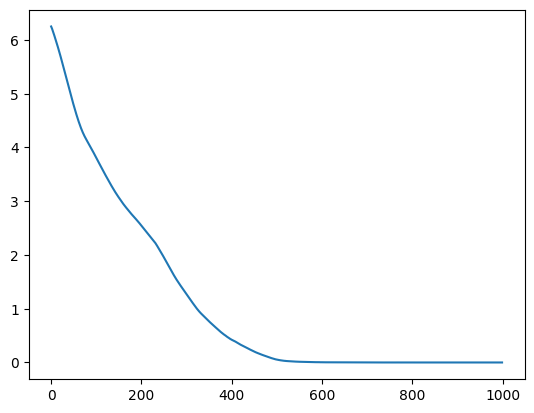

In [127]:
plt.plot(np.real(np.array(unitary_scores)))

In [129]:
unitary_scores[-1]

(5.6466694838164244e-05+8.446672113059633e-16j)

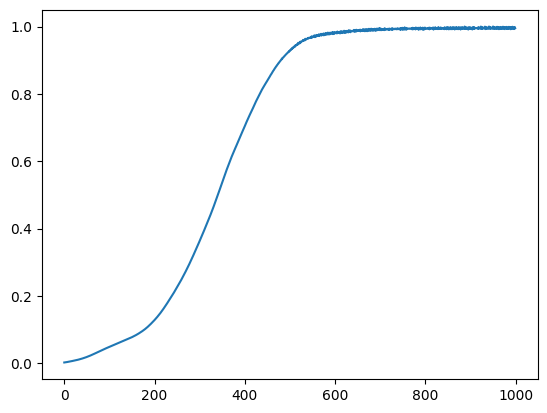

In [128]:
plt.plot(overlaps)

In [130]:
overlaps[-1]

0.9953819888586644

# SPT definitions

In [131]:
from itertools import combinations

In [132]:
symmetry_combination_labels = list(combinations(symmetry_labels, 2))

In [133]:
symmetry_combination_labels

[('II', 'IX'),
 ('II', 'XI'),
 ('II', 'XX'),
 ('IX', 'XI'),
 ('IX', 'XX'),
 ('XI', 'XX')]

In [134]:
e, a, b, c = symmetry_labels

In [135]:
group_products = [
    (a, b, c),
    (b, a, c),
    (a, c, b),
    (c, a, b),
    (c, b, a),
    (b, c, a)
]

# Sweep

In [136]:
num_sites = 6

In [137]:
unitarity_learning_rate = 1
overlap_learning_rate = 10

adam_params = (1e-3, 0.4, 0.4)

In [138]:
total_dimension = 2**num_sites

In [139]:
num_iterations = 1000

In [140]:
bond_dimension=5

In [141]:
physical_dims = [2,]*num_sites
virtual_dims = (
    [(None, bond_dimension),] +
    [(bond_dimension, bond_dimension)]*(num_sites - 2) +
    [(bond_dimension, None),]
)

In [143]:
solutions = list()
unitarity_scores = list()
overlap_scores = list()

for i, l in enumerate(cases):
    print(i)

    solutions.append(list())
    unitarity_scores.append(list())
    overlap_scores.append(list())
    
    for c in l[1:]:
        (
            left_mpo_tensors,
            right_mpo_tensors,
            left_b_tensors,
            right_b_tensors,
            unitarity_learning_rate,
            overlap_learning_rate,
            symmetry_transfer_matrix,
            left_adam_optimizers,
            right_adam_optimizers
        ) = initialize_optimization(
            num_sites,
            bond_dimension,
            c,
            unitarity_learning_rate,
            overlap_learning_rate,
            adam_params
        )

        current_unitarity_scores = list()
        current_overlap_scores = list()

        for _ in range(num_iterations):
            unitarity, overlap = two_sided_mpo_gradient_descent_sweep(
                left_mpo_tensors,
                right_mpo_tensors,
                left_b_tensors,
                right_b_tensors,
                unitarity_learning_rate,
                overlap_learning_rate,
                symmetry_transfer_matrix,
                left_adam_optimizers,
                right_adam_optimizers
            )
        
            current_unitarity_scores.append(unitarity)
            current_overlap_scores.append(overlap)

        solutions[-1].append((left_mpo_tensors, right_mpo_tensors))
        unitarity_scores[-1].append(current_unitarity_scores)
        overlap_scores[-1].append(current_overlap_scores)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


In [151]:
right_phases = list()

for l_c, l_s in zip(cases, solutions):

    solutions.append(list())

    solutions_dict = {
        v: k[1] for v, k in zip(symmetry_labels[1:], l_s)
    }

    b_tensors = [
        l_c[0].psi.get_B(i)
        for i in range(l_c[0].right_symmetry_index + 1, l_c[0].right_symmetry_index + 1 + num_sites)
    ]

    current_phases = [
        proj_rep_phase(
            l_c[0].right_projected_symmetry_state,
            b_tensors,
            solutions_dict[l1],
            solutions_dict[l2],
            solutions_dict[l3],
        )
        for l1, l2, l3 in group_products
    ]

    right_phases.append(current_phases)

In [152]:
phases_array = np.array(right_phases)

In [153]:
gauge_invariant_phases = phases_array[:,::2]/phases_array[:,1::2]

In [154]:
np.round(gauge_invariant_phases, 3)

array([[-0.999-4.000e-03j, -0.999-4.000e-03j, -1.   -3.000e-03j],
       [-1.   -0.000e+00j, -1.   +1.000e-03j, -1.   +0.000e+00j],
       [-0.997+2.000e-03j, -1.   -0.000e+00j, -0.995+2.000e-03j],
       [-1.005-8.000e-03j, -0.998+9.000e-03j, -0.998+3.200e-02j],
       [-0.941+8.000e-03j, -0.998+1.000e-03j, -0.946+9.000e-03j],
       [-1.027-5.800e-02j, -1.022+5.000e-03j, -0.883+2.100e-02j],
       [-0.999-0.000e+00j, -0.999-2.000e-03j, -1.001+0.000e+00j],
       [-0.998+7.000e-03j, -1.005+7.000e-03j, -1.001+3.000e-03j],
       [-0.995-2.000e-03j, -1.001-2.000e-03j, -1.005+2.000e-03j],
       [-0.989-6.000e-03j, -0.993-5.000e-03j, -0.997-5.000e-03j],
       [-3.418+1.220e-01j,  0.137-8.840e-01j,  0.061+1.189e+00j],
       [ 0.991+1.000e-03j,  0.986+4.000e-03j,  1.007-5.000e-03j],
       [ 0.996-5.000e-03j,  0.994+1.300e-02j,  1.004-1.000e-03j],
       [ 1.037+3.000e-02j,  0.948+0.000e+00j,  1.024-2.000e-02j],
       [ 1.017-8.000e-03j,  0.982-1.000e-03j,  0.997+8.000e-03j],
       [ 0

In [155]:
np.round(gauge_invariant_phases, 3)[:10]

array([[-0.999-0.004j, -0.999-0.004j, -1.   -0.003j],
       [-1.   -0.j   , -1.   +0.001j, -1.   +0.j   ],
       [-0.997+0.002j, -1.   -0.j   , -0.995+0.002j],
       [-1.005-0.008j, -0.998+0.009j, -0.998+0.032j],
       [-0.941+0.008j, -0.998+0.001j, -0.946+0.009j],
       [-1.027-0.058j, -1.022+0.005j, -0.883+0.021j],
       [-0.999-0.j   , -0.999-0.002j, -1.001+0.j   ],
       [-0.998+0.007j, -1.005+0.007j, -1.001+0.003j],
       [-0.995-0.002j, -1.001-0.002j, -1.005+0.002j],
       [-0.989-0.006j, -0.993-0.005j, -0.997-0.005j]])

In [156]:
np.round(gauge_invariant_phases, 3)[11:]

array([[0.991+0.001j, 0.986+0.004j, 1.007-0.005j],
       [0.996-0.005j, 0.994+0.013j, 1.004-0.001j],
       [1.037+0.03j , 0.948+0.j   , 1.024-0.02j ],
       [1.017-0.008j, 0.982-0.001j, 0.997+0.008j],
       [0.999-0.001j, 0.983-0.004j, 1.   +0.004j],
       [1.019-0.018j, 1.002+0.002j, 0.991+0.018j],
       [0.998-0.002j, 0.988-0.003j, 1.   -0.023j],
       [0.987-0.001j, 0.996-0.008j, 0.987+0.008j],
       [1.001-0.01j , 1.015+0.008j, 0.999-0.002j],
       [0.994-0.j   , 0.965-0.035j, 1.035-0.019j]])

In [161]:
left_phases = list()

for l_c, l_s in zip(cases, solutions):

    solutions.append(list())

    solutions_dict = {
        v: k[0] for v, k in zip(symmetry_labels[1:], l_s)
    }

    b_tensors = [
        l_c[0].psi.get_B(i, form='A')
        for i in range(l_c[0].left_symmetry_index - 1, l_c[0].left_symmetry_index - 1 - num_sites, -1)
    ]

    b_tensors = [swap_left_right_indices(b) for b in b_tensors]

    current_phases = [
        proj_rep_phase(
            swap_left_right_indices(l_c[0].left_projected_symmetry_state),
            b_tensors,
            solutions_dict[l1],
            solutions_dict[l2],
            solutions_dict[l3],
        )
        for l1, l2, l3 in group_products
    ]

    left_phases.append(current_phases)

In [162]:
phases_array = np.array(left_phases)

In [163]:
gauge_invariant_phases = phases_array[:,::2]/phases_array[:,1::2]

In [164]:
np.round(gauge_invariant_phases, 3)

array([[-0.986-5.000e-03j, -1.02 -4.000e-03j, -0.992-1.400e-02j],
       [-1.006+1.000e-03j, -1.006-2.000e-03j, -0.995-2.000e-03j],
       [-1.008+6.000e-03j, -1.009-2.100e-02j, -1.004-6.000e-03j],
       [-1.   -0.000e+00j, -1.   +2.000e-03j, -0.998+0.000e+00j],
       [-1.011+2.000e-03j, -0.997-1.900e-02j, -0.994+1.600e-02j],
       [-1.032-4.800e-02j, -1.009+3.600e-02j, -1.034+1.100e-02j],
       [-0.999-2.000e-03j, -0.997-3.000e-03j, -0.996-2.000e-03j],
       [-1.002+2.000e-03j, -1.001-1.000e-03j, -1.003-1.000e-03j],
       [-1.001-2.000e-02j, -1.004-6.000e-03j, -1.005+1.000e-02j],
       [-1.   +0.000e+00j, -1.   -0.000e+00j, -1.002-0.000e+00j],
       [-0.853+1.544e+00j, -0.952+6.500e-02j,  0.091-6.950e-01j],
       [ 1.001+3.000e-03j,  1.002+1.000e-03j,  1.005+3.000e-03j],
       [ 1.007-2.600e-02j,  1.007-8.000e-03j,  0.982+1.200e-02j],
       [ 1.011+1.000e-03j,  1.007+5.000e-03j,  1.03 +2.000e-03j],
       [ 0.975-4.200e-02j,  1.013-2.400e-02j,  0.991+2.200e-02j],
       [ 1

In [165]:
np.round(gauge_invariant_phases, 3)[:10]

array([[-0.986-0.005j, -1.02 -0.004j, -0.992-0.014j],
       [-1.006+0.001j, -1.006-0.002j, -0.995-0.002j],
       [-1.008+0.006j, -1.009-0.021j, -1.004-0.006j],
       [-1.   -0.j   , -1.   +0.002j, -0.998+0.j   ],
       [-1.011+0.002j, -0.997-0.019j, -0.994+0.016j],
       [-1.032-0.048j, -1.009+0.036j, -1.034+0.011j],
       [-0.999-0.002j, -0.997-0.003j, -0.996-0.002j],
       [-1.002+0.002j, -1.001-0.001j, -1.003-0.001j],
       [-1.001-0.02j , -1.004-0.006j, -1.005+0.01j ],
       [-1.   +0.j   , -1.   -0.j   , -1.002-0.j   ]])

In [166]:
np.round(gauge_invariant_phases, 3)[11:]

array([[1.001+0.003j, 1.002+0.001j, 1.005+0.003j],
       [1.007-0.026j, 1.007-0.008j, 0.982+0.012j],
       [1.011+0.001j, 1.007+0.005j, 1.03 +0.002j],
       [0.975-0.042j, 1.013-0.024j, 0.991+0.022j],
       [1.001+0.006j, 1.008-0.019j, 1.008+0.001j],
       [1.003-0.009j, 1.019-0.022j, 1.003-0.004j],
       [1.007+0.018j, 0.986+0.015j, 1.012+0.006j],
       [0.991+0.005j, 1.012+0.005j, 1.025+0.003j],
       [1.009+0.001j, 0.988-0.006j, 1.   -0.003j],
       [0.997+0.007j, 0.995+0.01j , 0.994+0.012j]])

# Conclusions
* It works! Could be more precise perhaps with better optimization, but it works!